In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from grr.Simulation import GIFnet_Simulation

# Load data

In [3]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'subsample_base')
simfiles = {}
for fname in os.listdir(DATA_PATH):
    if fname[-4:].lower() == 'hdf5':
        try:
            simfiles[fname[:-5]] = GIFnet_Simulation(os.path.join(DATA_PATH, fname))
        except IOError:
            warnings.warn('Problem with file {}. Continuing.'.format(fname), RuntimeWarning)
    else:
        continue

## Data format

Each simulation is stored in its own HDF5 file. The `GIFnet_Simulation` class simply provides a convenient interface for creating and accessing these files.

In [4]:
simfiles

{'m_g_1': <HDF5 file "m_g_1.hdf5" (mode r+)>,
 'm_g_10': <HDF5 file "m_g_10.hdf5" (mode r+)>,
 'm_g_11': <HDF5 file "m_g_11.hdf5" (mode r+)>,
 'm_g_12': <HDF5 file "m_g_12.hdf5" (mode r+)>,
 'm_g_13': <HDF5 file "m_g_13.hdf5" (mode r+)>,
 'm_g_14': <HDF5 file "m_g_14.hdf5" (mode r+)>,
 'm_g_15': <HDF5 file "m_g_15.hdf5" (mode r+)>,
 'm_g_2': <HDF5 file "m_g_2.hdf5" (mode r+)>,
 'm_g_3': <HDF5 file "m_g_3.hdf5" (mode r+)>,
 'm_g_4': <HDF5 file "m_g_4.hdf5" (mode r+)>,
 'm_g_5': <HDF5 file "m_g_5.hdf5" (mode r+)>,
 'm_g_6': <HDF5 file "m_g_6.hdf5" (mode r+)>,
 'm_g_7': <HDF5 file "m_g_7.hdf5" (mode r+)>,
 'm_g_8': <HDF5 file "m_g_8.hdf5" (mode r+)>,
 'm_g_9': <HDF5 file "m_g_9.hdf5" (mode r+)>,
 'm_ng_1': <HDF5 file "m_ng_1.hdf5" (mode r+)>,
 'm_ng_10': <HDF5 file "m_ng_10.hdf5" (mode r+)>,
 'm_ng_11': <HDF5 file "m_ng_11.hdf5" (mode r+)>,
 'm_ng_12': <HDF5 file "m_ng_12.hdf5" (mode r+)>,
 'm_ng_13': <HDF5 file "m_ng_13.hdf5" (mode r+)>,
 'm_ng_14': <HDF5 file "m_ng_14.hdf5" (mode r+)>,


The filenames are stuctured as follows: `{l,m}_{g,ng}_n`, where `{l,m}` indicates the baseline (low or mid), `{g,ng}` indicates whether GABA cells are included in the simulation (gaba, no gaba), and `n` is the replicate number. Replicates use different random seeds.

In [6]:
dir(simfiles['m_g_1'])

['_MutableMapping__marker',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__iter__',
 '__len__',
 '__metaclass__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_d',
 '_e',
 '_gcpl_crt_order',
 '_id',
 '_lapl',
 '_lcpl',
 '_swmr_mode',
 'attrs',
 'clear',
 'close',
 'copy',
 'create_dataset',
 'create_dataset_like',
 'create_group',
 'create_virtual_dataset',
 'driver',
 'fid',
 'file',
 'filename',
 'flush',
 'gaba_examples',
 'gaba_spktrains',
 'get',
 'get_T',
 'get_connectivity_matrix',
 'get_dt',
 'get_gaba_examples_supp',
 'get_gaba_spktimes',
 'get_

Here we're mainly interested in example traces.

In [7]:
simfiles['m_g_1'].ser_examples.keys()

[u'I', u'V', u'feedforward_input']

Example traces are stored in a dict with the above keys. Note that here `'I'` is *distal* input only, whereas `'feedforward_input'` is *local* input only. Therefore, the *total* input to 5HT cells is `obj.ser_examples['I'] + obj.ser_examples['feedforward_input']`. (As of 2019.09.04.)

# Network structure

The network being simulated is comprised of two populations: 5HT and GABA cells. Both receive input from some external source, and the GABA cells are connected to the 5HT cells as below, with 5HT cells as rows and GABA cells as columns.

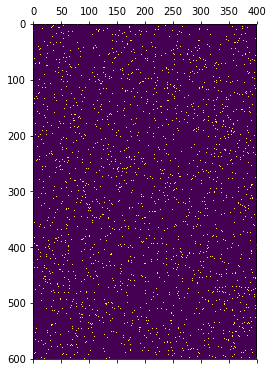

In [8]:
condition = 'm_g_1'
plt.matshow(simfiles[condition].get_connectivity_matrix())

In [9]:
print('Max weight: {:>16}'.format(np.max(simfiles[condition].get_connectivity_matrix())))
print('Min weight: {:>16}'.format(np.max(simfiles[condition].get_connectivity_matrix())))
print('Inputs/5HT cell: {:>11.1f}'.format(np.sum(simfiles[condition].get_connectivity_matrix(), axis=1).mean()))
print('Propagation delay: {:>9.1f}ms'.format(simfiles[condition].get_propagation_delay()))

Max weight:              1.0
Min weight:              1.0
Inputs/5HT cell:         9.8
Propagation delay:      20.0ms


# Input to 5HT cells

In these simulations, 5HT cells receive direct excitatory input from an external source, as well as feedforward input from local GABA interneurons. The external input contains some noise that differs between cells. The feedforward input also varies between 5HT cells due to random local connectivity.

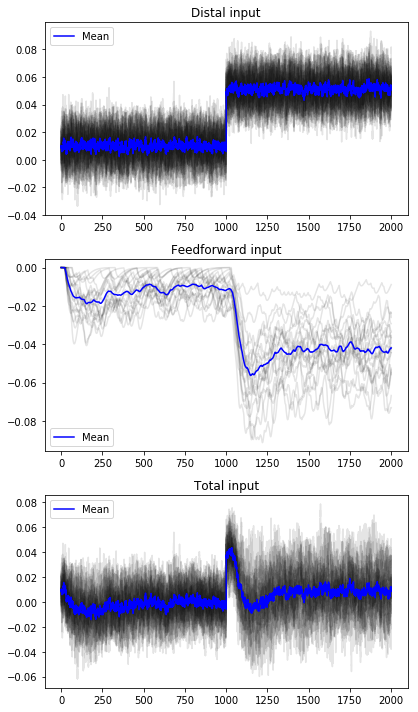

In [10]:
condition = 'm_g_1'
sweep_no = 7

plt.figure(figsize=(6,10))

plt.subplot(311)
plt.title('Distal input')
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, ...].T,
    simfiles[condition].ser_examples['I'][sweep_no, ...].T,
    'k-', alpha = 0.1
)
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, 0, ...].T,
    np.mean(simfiles[condition].ser_examples['I'][sweep_no, ...].T, axis=1),
    'b-', label='Mean'
)
plt.legend()

plt.subplot(312)
plt.title('Feedforward input')
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, ...].T,
    simfiles[condition].ser_examples['feedforward_input'][sweep_no, ...].T,
    'k-', alpha = 0.1
)
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, 0, ...].T,
    np.mean(simfiles[condition].ser_examples['feedforward_input'][sweep_no, ...].T, axis=1),
    'b-', label='Mean'
)
plt.legend()

plt.subplot(313)
plt.title('Total input')
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, ...].T,
    simfiles[condition].ser_examples['I'][sweep_no, ...].T
    + simfiles[condition].ser_examples['feedforward_input'][sweep_no, ...].T,
    'k-', alpha = 0.1
)
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, 0, ...].T,
    np.mean(
        simfiles[condition].ser_examples['I'][sweep_no, ...].T
        + simfiles[condition].ser_examples['feedforward_input'][sweep_no, ...].T, 
        axis=1
    ),
    'b-', label='Mean'
)
plt.legend()

plt.tight_layout()
plt.show()

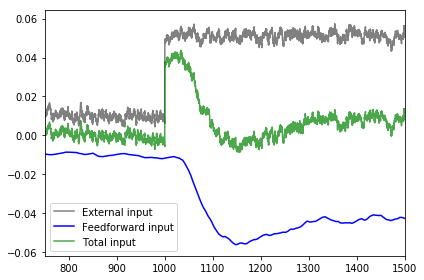

In [11]:
# Reuse `condition` and `sweep_no` from previous cell.

plt.figure()

plt.subplot(111)
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, 0, ...].T,
    np.mean(simfiles[condition].ser_examples['I'][sweep_no, ...].T, axis=1),
    '-', color='gray', label='External input'
)
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, 0, ...].T,
    np.mean(simfiles[condition].ser_examples['feedforward_input'][sweep_no, ...].T, axis=1),
    'b-', label='Feedforward input'
)
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, 0, ...].T,
    np.mean(
        simfiles[condition].ser_examples['I'][sweep_no, ...].T
        + simfiles[condition].ser_examples['feedforward_input'][sweep_no, ...].T, 
        axis=1
    ),
    '-', color='green', alpha=0.7, label='Total input'
)
plt.xlim(750, 1500)
plt.legend()

plt.tight_layout()
plt.show()

Notice that the feedforward input lags the external input slightly. This is due to the propagation delay and the time constant of the GABA cells.

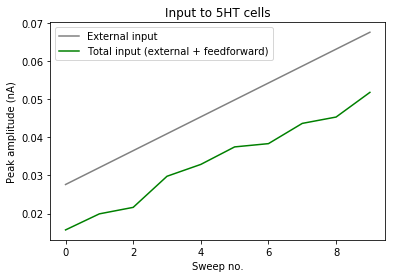

In [12]:
# Reuse `condition` and `sweep_no` from previous cell.

plt.figure()

plt.subplot(111)
plt.title('Input to 5HT cells')
plt.plot(np.max(np.mean(simfiles[condition].ser_examples['I'], axis=1), axis=1), color='gray', label='External input')
plt.plot(
    np.max(
        np.mean(
            simfiles[condition].ser_examples['I'][...] 
            + simfiles[condition].ser_examples['feedforward_input'][...], 
            axis=1
        ), 
        axis=1
    ),
    color='g', label='Total input (external + feedforward)'
)
plt.legend()
plt.ylabel('Peak amplitude (nA)')
plt.xlabel('Sweep no.')

plt.show()

The GABA cells have a small subtractive effect on the peak amplitude of the input pulse. This is due to tonic GABA activity.

# Sample behaviour

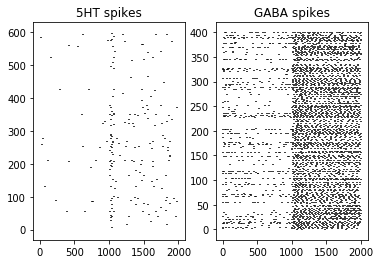

In [13]:
condition = 'm_g_8'
sweep_no = 9

plt.subplot(121)
plt.title('5HT spikes')
plt.eventplot(simfiles[condition].get_ser_spktimes()[sweep_no], color='k')

plt.subplot(122)
plt.title('GABA spikes')
plt.eventplot(simfiles[condition].get_gaba_spktimes()[sweep_no], color = 'k')
plt.show()

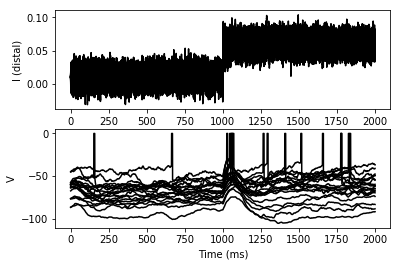

In [14]:
# Reuse `condition` and `sweep_no` from previous cell.

plt.subplot(211)
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, ...].T,
    simfiles[condition].ser_examples['I'][sweep_no, ...].T, 'k-'
)
plt.ylabel('I (distal)')

plt.subplot(212)
plt.plot(
    simfiles[condition].get_ser_examples_supp()[sweep_no, ...].T,
    simfiles[condition].ser_examples['V'][sweep_no, ...].T, 'k-'
)
plt.ylabel('V')
plt.xlabel('Time (ms)')

plt.show()